# Preprocessing Data

In [22]:
# import all the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL
import PIL.Image
import tensorflow as tf
from keras import utils as np_utils
# import tensorflow_datasets as tfds

In [23]:
# make sure that on your systems you have the same tensorflow version installed and all the libraries as well
# for **matplotlib**, I am running version 3.4.3  

print("Numpy Version: ",np.__version__)
print("Pillow Version: ", PIL.__version__)
print("TensorFlow Version: ",tf.__version__)
# print("TensorFlow Dataset Version: ",tfds.__version__)

Numpy Version:  1.23.5
Pillow Version:  9.2.0
TensorFlow Version:  2.13.0-dev20230412


In [24]:
# now we will set the path:
# for this jupyter notebook, I am doing inside the repo folder

data_path = pathlib.Path("../DATA").with_suffix('')
print(data_path)

../DATA


In [25]:
# check to see how many images are in the folder

images_count = len(list(data_path.glob('*/*.jpeg')))
print(images_count)

3091


If you run this code and you get only 2000 images, it could be Github can only allow 1000 files for each folder. If this is the case, you can replace the data file from Github with the data file from Kaggle instead!

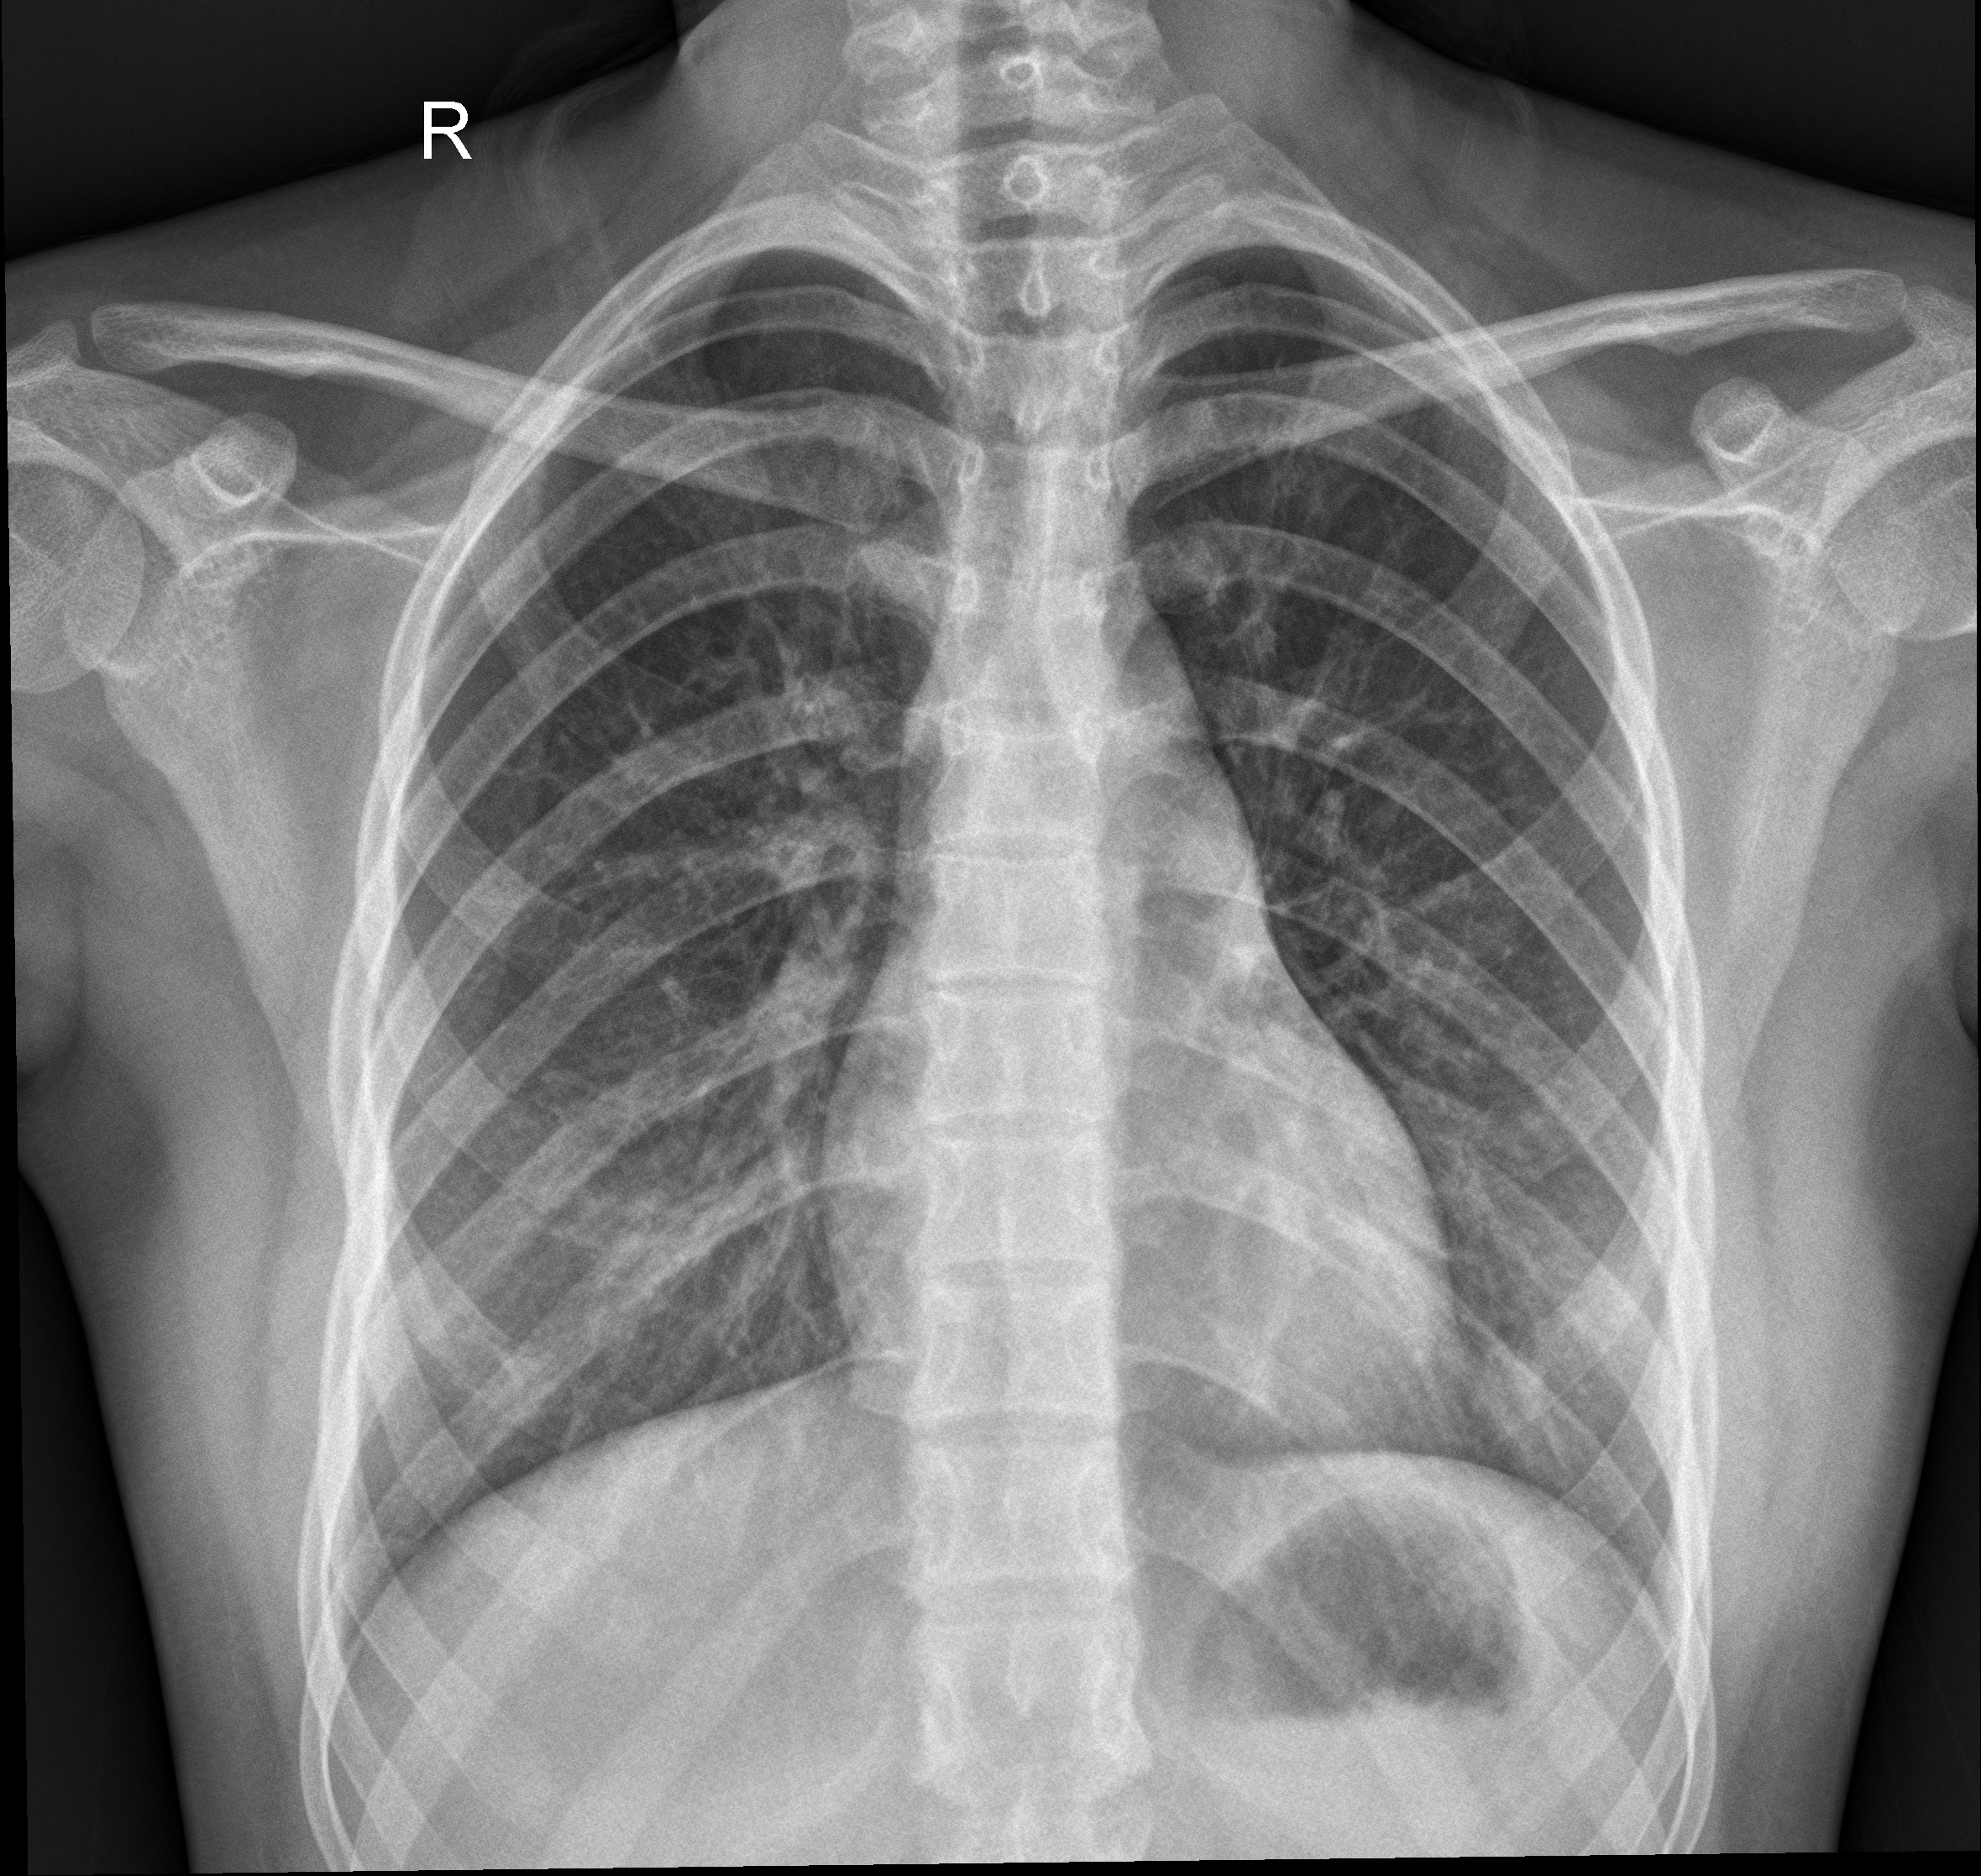

In [26]:
# print out a sample: 0 - Without Covid

wOut_Covid = list(data_path.glob('0/*'))
PIL.Image.open(str(wOut_Covid[0]))

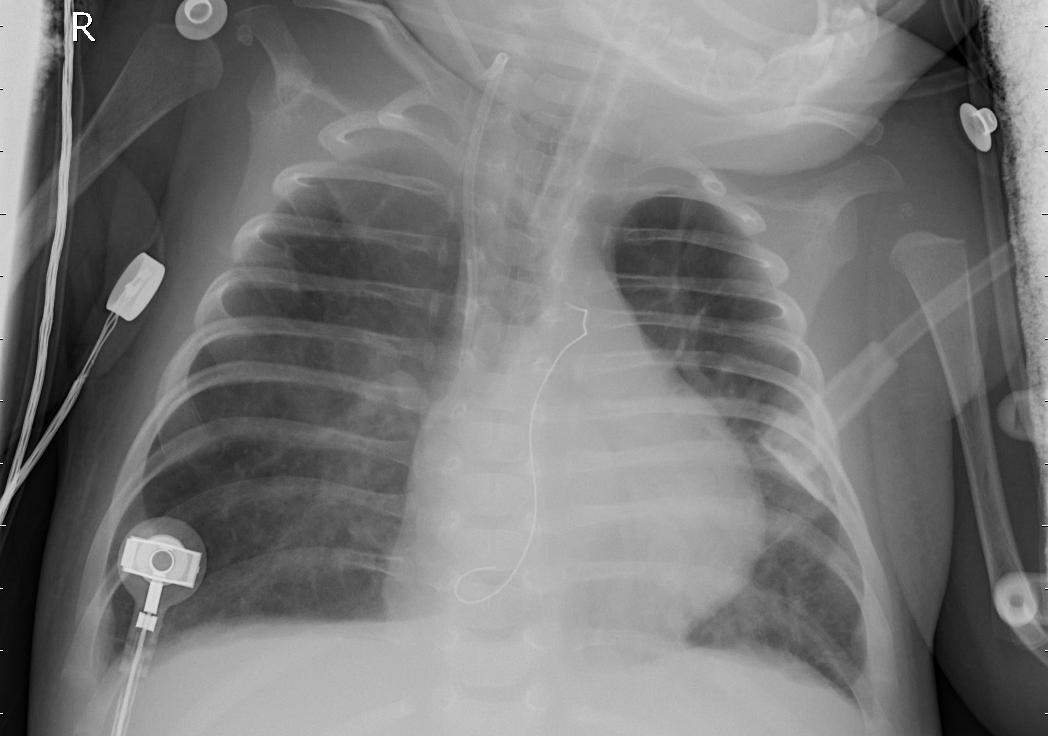

In [27]:
# print out a sample: 1 - With Covid

wOut_Covid = list(data_path.glob('1/*'))
PIL.Image.open(str(wOut_Covid[0]))

Since certain images are larger than others, lets start by specifying the batch size and the image width and height.

In [28]:
# specify the batch size and the image size for the training

batch_size = 32 # smaller bathes gives better results
height = 200
width = 200

In [29]:
# augmentation, which is then applied to the raining model only

image_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), # images are randomly flipped during training
    tf.keras.layers.RandomRotation(0.2) # images are randomly rotated during training
])

In [30]:
# create the data set for training

train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=.2,
    subset="training",
    seed=123,
    image_size=(height,width),
    batch_size=batch_size
)

Found 3091 files belonging to 2 classes.
Using 2473 files for training.


In [31]:
# create the data set for validation

validate_dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=.2,
    subset="validation",
    seed=123,
    image_size=(height,width),
    batch_size=batch_size
)

Found 3091 files belonging to 2 classes.
Using 618 files for validation.


Just remember that:   
0 = Without covid  
1 = With Covid  

In [32]:
# finding the class names

class_names = train_dataset.class_names
print(class_names)

['0', '1']


2023-04-12 21:14:10.768520: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2473]
	 [[{{node Placeholder/_4}}]]
2023-04-12 21:14:10.769166: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2473]
	 [[{{node Placeholder/_4}}]]


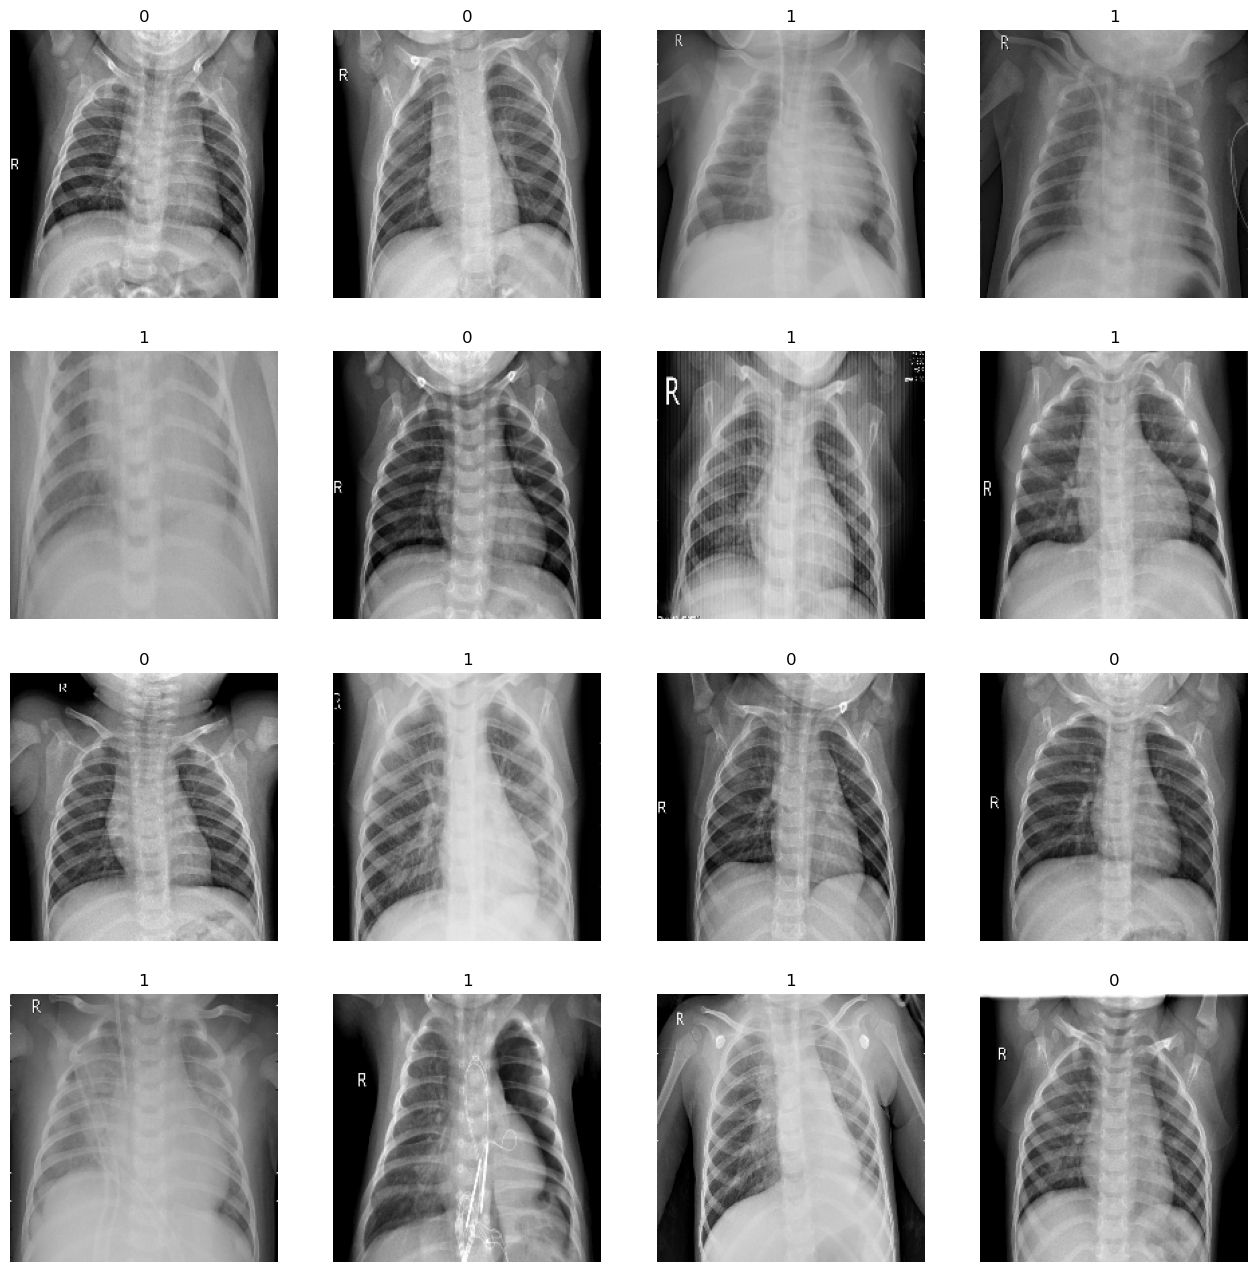

In [33]:
# visualize the data: visual purposes (optional)
# set the size of the figure

plt.figure(figsize=(16,16))

# loop through the training dataset and pull out some examples
for images, labels in train_dataset.take(1):
    for x in range(16):
        ax = plt.subplot(4, 4, x + 1)
        plt.imshow(images[x].numpy().astype("uint8"))
        plt.title(class_names[labels[x]])
        plt.axis('off')


Great! The images look pretty good! Typically, with color images, you would need to rescale the values since RGB colors range from 0 -> 255. Even though our images looks like it consists of black and white we will rescale and standardize it from 0 -> 1 instead. 

In [34]:
# rescaling

normalized = tf.keras.layers.Rescaling(1./255)

In [35]:
# now, lets normalize the training dataset

normalized_trainDS = train_dataset.map(lambda x, y: (normalized(x),y))
image_group, label_group = next(iter(normalized_trainDS))

2023-04-12 21:14:12.392588: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2473]
	 [[{{node Placeholder/_4}}]]
2023-04-12 21:14:12.392926: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2473]
	 [[{{node Placeholder/_4}}]]


In [36]:
# pull an example from the group to see

image = image_group[0]
print(np.min(image),np.max(image))

0.0 1.0


# Models

### Reference Model TensorFlow

I will add a model, courtesy of TensorFlow to compare with our models.** This preprocessing coding was written with the guidance of TensorFlow's Load and PreProcess Data Webpage. [Link Here](https://www.tensorflow.org/tutorials/load_data/images)

Here, we will configure the dataset for performance and then train a model using Keras Sequential.

In [37]:
# configuring the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validate_dataset = validate_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
# create our model

num_classes = 2 # with and without covid

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [39]:
# compile to model build it for accuracy

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [40]:
# now we fit the model and see we get! 

model.fit(
  train_dataset,
  validation_data=validate_dataset,
  epochs=3
)

Epoch 1/3


2023-04-12 21:14:13.344162: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2473]
	 [[{{node Placeholder/_0}}]]
2023-04-12 21:14:13.344851: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2473]
	 [[{{node Placeholder/_0}}]]


78/78 [==============================] - ETA: 0s - loss: 0.4608 - accuracy: 0.7695

2023-04-12 21:14:55.774590: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [618]
	 [[{{node Placeholder/_4}}]]
2023-04-12 21:14:55.775139: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [618]
	 [[{{node Placeholder/_0}}]]


78/78 [==============================] - 46s 569ms/step - loss: 0.4608 - accuracy: 0.7695 - val_loss: 0.1638 - val_accuracy: 0.9353
Epoch 2/3
78/78 [==============================] - 41s 518ms/step - loss: 0.1729 - accuracy: 0.9381 - val_loss: 0.0942 - val_accuracy: 0.9628
Epoch 3/3
78/78 [==============================] - 41s 522ms/step - loss: 0.1143 - accuracy: 0.9596 - val_loss: 0.0729 - val_accuracy: 0.9709


Since we set the epochs to 3 times, the training time is faster compared to epochs = 10.

##### Here is an example of finding the precision of our model

In [44]:
# create our model
num_classes = 1 # since we only have 0 and 1 -> binary

model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

In [42]:
model2.compile(
  optimizer='Adam', 
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=[tf.keras.metrics.Precision()])


In [43]:
model2.fit(
  train_dataset,
  validation_data=validate_dataset,
  epochs=3
)

Epoch 1/3
78/78 [==============================] - 45s 562ms/step - loss: 0.6821 - precision_1: 0.6249 - val_loss: 0.7944 - val_precision_1: 0.0000e+00
Epoch 2/3
78/78 [==============================] - 43s 556ms/step - loss: 0.5241 - precision_1: 0.7425 - val_loss: 0.3976 - val_precision_1: 0.9856
Epoch 3/3
78/78 [==============================] - 43s 553ms/step - loss: 0.3662 - precision_1: 0.8637 - val_loss: 0.2372 - val_precision_1: 0.9415


### ResNet50